In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

from brainpedia.brainpedia import Brainpedia
from brainpedia.fmri_processing import invert_preprocessor_scaling
from models.ICW_FMRI_GAN import Critic, Generator
from nilearn import plotting
from torch.autograd import Variable
from tqdm import tqdm

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Setup data directory and cache directory paths to store preprocessed data.

In [2]:
DATA_DIR = 'neurovault/collection_1952/'
CACHE_DIR = 'neurovault/preprocessed_collection_1952/'

Fix random seed for reproducibility.

In [3]:
np.random.seed(1)

CUDA = torch.cuda.is_available()
if CUDA:
    torch.cuda.manual_seed(1)
else:
    torch.manual_seed(1)

Setup model hyperparameters.

In [4]:
DOWNSAMPLE_SCALE = 0.25
BATCH_SIZE = 32

MODEL_DIMENSIONALITY = 64
CONDITONING_DIMENSIONALITY = 5

CRITIC_UPDATES_PER_GENERATOR_UPDATE = 1

NOISE_SAMPLE_LENGTH = 128

# Data

Load the full [Neurovault](https://neurovault.org) Collection 1952 [BrainPedia](https://neurovault.org/collections/1952/) dataset into memory.

In [5]:
brainpedia = Brainpedia(data_dirs=[DATA_DIR],
                        cache_dir=CACHE_DIR,
                        scale=DOWNSAMPLE_SCALE)
all_brain_data, all_brain_data_tags = brainpedia.all_data()
brainpedia_batch_generator = Brainpedia.batch_generator(all_brain_data, all_brain_data_tags, BATCH_SIZE, CUDA)
brain_data_shape, brain_data_tag_shape = brainpedia.sample_shapes()

### Plot Example Data Point

Grab an example brain volume and upsample.

In [6]:
all_brain_data.shape

(6573, 1, 13, 15, 11)

In [7]:
example_brain_data = all_brain_data[0].squeeze()
example_brain_data.shape

(13, 15, 11)

In [8]:
upsampled_example_brain_data = invert_preprocessor_scaling(example_brain_data, brainpedia.preprocessor)
upsampled_example_brain_data.shape

(53, 63, 46, 1)

Grab the task description tags for the example brain volume and decode the one-hot encoded tags vector to their english descriptions.

In [9]:
all_brain_data_tags.shape

(6573, 19)

In [10]:
example_brain_data_tags = all_brain_data_tags[0]
example_brain_data_tags

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [11]:
example_brain_data_decoded_tags = brainpedia.preprocessor.decode_label(example_brain_data_tags)
example_brain_data_decoded_tags

['calculation', 'visual words', 'visual']

Plot example brain volume and their task description tags.

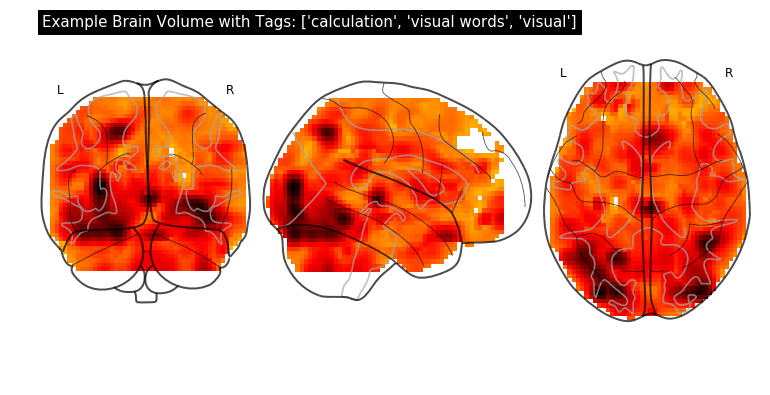

In [12]:
figure = plt.figure(figsize=(10, 5))
plotting.plot_glass_brain(stat_map_img=upsampled_example_brain_data,
                          threshold='auto',
                          title="Example Brain Volume with Tags: {0}".format(example_brain_data_decoded_tags),
                          figure=figure)
plt.show()

# Models

Construct models.

NOTE: Depending on the hyperparameter settings above, the dimensionality of the label vector, noise vector, and layers may not exactly match the figure below.

![ICW-fMRI-GAN Model Architecture](models/resources/architecture.png)

In [13]:
generator = Generator(input_size=NOISE_SAMPLE_LENGTH,
                      output_shape=brain_data_shape,
                      dimensionality=MODEL_DIMENSIONALITY,
                      num_classes=brain_data_tag_shape[0],
                      conditioning_dimensionality=CONDITONING_DIMENSIONALITY,
                      cudaEnabled=CUDA)
critic = Critic(dimensionality=MODEL_DIMENSIONALITY,
                num_classes=brain_data_tag_shape[0],
                conditioning_dimensionality=CONDITONING_DIMENSIONALITY,
                cudaEnabled=CUDA)

#### Load and Save Pretrained Models

In [14]:
generator_weight_path = 'models/weights/generator.pt'
critic_weight_path = 'models/weights/critic.pt'
epoch_weight_path = 'models/weights/epoch.npy'

In [15]:
def save_checkpoint(epoch):
    torch.save(generator.state_dict(), generator_weight_path)
    torch.save(critic.state_dict(), critic_weight_path)
    np.save(epoch_weight_path, epoch)

In [16]:
def load_checkpoint():
    epochs_trained = 0
    if os.path.exists(generator_weight_path) and os.path.exists(critic_weight_path) and os.path.exists(epoch_weight_path):
        generator.load_state_dict(torch.load(generator_weight_path))
        critic.load_state_dict(torch.load(critic_weight_path))
        epochs_trained = np.load(epoch_weight_path) + 1
        print("Loaded models with {} epochs pretrained...".format(epochs_trained))
    else:
        print("Starting from scratch...")
    return epochs_trained

# Training

In [17]:
NUM_EPOCHS_TO_TRAIN = 5
LAMBDA = 10

Objective to optimize:

![ICW-fMRI-GAN Model Objective](models/resources/objective.png)

In [18]:
def noise(size, cuda=False):
    noise = torch.from_numpy(np.random.normal(0.0, size=size)).float()
    if cuda:
        noise = noise.cuda()
    return noise

In [19]:
def train(epoch):
    
    sum_critic_loss = 0.0
    sum_generator_loss = 0.0
    
    for data_batch, label_batch in tqdm(brainpedia_batch_generator):
        
        data_batch = Variable(data_batch)
        label_batch = Variable(label_batch)
            
        # (1) Train critic to distinguish between real and synthetic brain samples
        for critic_step in range(CRITIC_UPDATES_PER_GENERATOR_UPDATE):

            # Generate synthetic data batch for true labels
            critic_noise_batch = Variable(noise(size=(label_batch.shape[0], NOISE_SAMPLE_LENGTH), cuda=CUDA))
            synthetic_data_batch = generator(critic_noise_batch, label_batch)
            
            # Train critic to distinguish between the real and synthetic brain samples
            critic_loss = critic.train(data_batch, synthetic_data_batch, label_batch, LAMBDA)
            sum_critic_loss += critic_loss.item()

        # (2) Train generator to fool critic
        generator_noise_batch = Variable(noise(size=(label_batch.shape[0], NOISE_SAMPLE_LENGTH), cuda=CUDA))
        synthetic_data_batch = generator(generator_noise_batch, label_batch)
        critic_predictions = critic(synthetic_data_batch, label_batch)
        generator_loss = generator.train(critic_predictions)
        sum_generator_loss += generator_loss.item()
                
    train_size = len(brainpedia_batch_generator)
    return sum_critic_loss / train_size, sum_generator_loss / train_size

In [20]:
epochs_pretrained = load_checkpoint()

for epoch in range(epochs_pretrained, epochs_pretrained+NUM_EPOCHS_TO_TRAIN):
    
    # Train for an epoch
    critic_loss, generator_loss = train(epoch)
    
    print("========= EPOCH {0} ==========".format(epoch))
    print("CRITIC LOSS   : {0:.4f}".format(critic_loss))
    print("GENERATOR LOSS: {0:.4f}\n".format(generator_loss))
    
    # Checkpoint model
    save_checkpoint(epoch)
    
    # Visualize model output
    

0it [00:00, ?it/s]

Starting from scratch...


/usr/local/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
13it [00:57,  4.32s/it]

KeyboardInterrupt: 

In [ ]:

#         # Upsample and save samples
#         sample_tags = brainpedia.preprocessor.decode_label(labels_batch.data[0])
#         real_sample_data = real_brain_img_data_batch[0].cpu().data.numpy().squeeze()
#         synthetic_sample_data = synthetic_brain_img_data_batch[0].cpu().data.numpy().squeeze()
#         upsampled_real_brain_img = invert_preprocessor_scaling(real_sample_data, brainpedia.preprocessor)
#         upsampled_synthetic_brain_img = invert_preprocessor_scaling(synthetic_sample_data, brainpedia.preprocessor)

#         real_sample_output_path = "{0}sample_{1}_real.nii.gz".format(DATA_OUTPUT_DIR, training_step)
#         synthetic_sample_output_path = "{0}sample_{1}_synthetic.nii.gz".format(DATA_OUTPUT_DIR, training_step)

#         nibabel.save(upsampled_real_brain_img, real_sample_output_path)
#         nibabel.save(upsampled_synthetic_brain_img, synthetic_sample_output_path)

#         # Compute correlation scores
#         real_sample_correlation = avg_correlation_of_image_to_images_in_brainpedia_with_same_tags(image_path=real_sample_output_path,
#                                                                                                   brainpedia=brainpedia,
#                                                                                                   tags=sample_tags)
#         synthetic_sample_correlation = avg_correlation_of_image_to_images_in_brainpedia_with_same_tags(image_path=synthetic_sample_output_path,
#                                                                                                        brainpedia=brainpedia,
#                                                                                                        tags=sample_tags)

#         # Visualize samples
#         title = "{0}".format(sample_tags)
#         Plot.plot_sample_brain_data(real_sample_brain_img=upsampled_real_brain_img,
#                                     synthetic_sample_brain_img=upsampled_synthetic_brain_img,
#                                     real_sample_correlation=real_sample_correlation,
#                                     synthetic_sample_correlation=synthetic_sample_correlation,
#                                     output_file="{0}sample_{1}".format(VIS_OUTPUT_DIR, training_step),
#                                     title=title)